## Dataset preparing

In [ ]:
from lxml import etree
from typing import List, Tuple, Optional


def load_sentirueval_2016(file_name: str) -> Tuple[List[str], List[str]]:
    """Load texts and labels from SentiRuEval 2016 XML file."""
    root = _read_xml_file(file_name)
    database = _find_first_database(root)
    texts, labels = _process_database_tables(database, file_name)
    return texts, labels


def _read_xml_file(file_name: str) -> etree._Element:
    with open(file_name, mode='rb') as fp:
        xml_data = fp.read()
    return etree.fromstring(xml_data)


def _find_first_database(root: etree._Element) -> etree._Element:
    """Find first database element in XML tree."""
    for element in root.getchildren():
        if element.tag == 'database':
            return element
    raise ValueError('No database element found in XML')


def _process_database_tables(database: etree._Element, file_name: str) -> Tuple[List[str], List[str]]:
    """Process all tables in database and extract texts and labels."""
    texts = []
    labels = []

    for table in database.getchildren():
        if table.tag != 'table':
            continue

        text, label = _process_table_columns(table)
        _validate_table_data(text, label, file_name)

        texts.append(text)
        labels.append(label)

    return texts, labels


def _process_table_columns(table: etree._Element) -> Tuple[Optional[str], Optional[str]]:
    """Extract text and label from table columns."""
    text = None
    label = None

    for column in table.getchildren():
        column_name = column.get('name')
        column_value = str(column.text).strip() if column.text else ''

        if column_name == 'text':
            text = column_value
        elif column_name not in {'id', 'twitid', 'date'}:
            label = _parse_label(column_value)
            # if column_value in ['1', '0', '-1']:
            #     label = column_value
            # elif column_value == 'NULL':
            #     label = '0'

        if text is not None and label is not None:
            break

    return text, label


def _parse_label(label_str: str) -> Optional[str]:
    """Convert numeric label to textual representation.
       Not nessesary for tf models"""
    if label_str == '-1':
        return 'negative'
    elif label_str == '1':
        return 'positive'
    elif label_str == '0':
        return 'neutral'
    return None

def _validate_table_data(text: Optional[str], label: Optional[str], file_name: str) -> None:
    """Validate that both text and label were found."""
    if text is None or label is None:
        raise ValueError(f'File `{file_name}` contains incomplete data (text or label missing)')


texts, labels = load_sentirueval_2016('bank_train_2016.xml')

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
def convert_labels(labels, label_map):
    new_labels = []
    for label in labels:
        new_label = label_map[label]
        new_labels.append(new_label)
    return new_labels

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
labels = convert_labels(labels, label_map)
labels = to_categorical(labels, num_classes=3) # для pt не использовать

In [ ]:
from sklearn.model_selection import train_test_split

t_texts, test_texts, t_labels, test_labels = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=2025)
train_texts, dev_texts, train_labels, dev_labels = t_texts[:5263], t_texts[5263:], t_labels[:5263], t_labels[5263:]

test_samples = [(text, label) for text, label in zip(test_texts, test_labels)]
train_samples = [(text, label) for text, label in zip(train_texts, train_labels)]
dev_samples = [(text, label) for text, label in zip(dev_texts, dev_labels)]

In [ ]:
print('Number of TRAIN texts is {0}, number of labels is {1}.'.format(len(train_texts), len(train_labels)))
print('Number of VAL texts is {0}, number of labels is {1}.'.format(len(dev_texts), len(dev_labels)))
print('Number of TEST texts is {0}, number of labels is {1}.'.format(len(test_texts), len(test_labels)))

Number of TRAIN texts is 5263, number of labels is 5263.
Number of VAL texts is 2250, number of labels is 2250.
Number of TEST texts is 1879, number of labels is 1879.


## Classes for tf-model

### Preparing model

In [ ]:
import torch
import tensorflow as tf
from transformers import BertModel, BertConfig, BertForSequenceClassification,
                          TFBertForTokenClassification, TFBertForSequenceClassification, BertTokenizer
import copy
from sklearn.model_selection import train_test_split

In [ ]:
def get_model(model_name):
    if model_name == 'tf_bert_for_sequence_classification':
        config = BertConfig.from_pretrained('DeepPavlov/rubert-base-cased', from_pt=True, num_labels=3)
        tf_model = TFBertForSequenceClassification.from_pretrained(
            "DeepPavlov/rubert-base-cased",
            from_pt=True,
            config=config
        )
        #tf_model.layers[-1].activation = tf.keras.activations.softmax
        #tf_model.layers[-1].trainable = True
        return tf_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
tf_model = get_model('tf_bert_for_sequence_classification')
# tf_model.load_weights('/content/drive/MyDrive/weights/senti_classification_3_weights.h5')
tf_model.load_weights('/content/RUbert_cross_domain_main_weights.h5')
tf_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForTokenClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177262848 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 177265155 (676.21 MB)
Trainable params: 177265155 (676.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Как работает `TFBertForSequenceClassification`:

* На выходе BERT для классификации последовательностей обычно используется специальный токен [CLS], который агрегирует информацию обо всей последовательности.
Вектор, соответствующий этому токену, передаётся в классификатор.

* Слой `tf.keras.layers.Dense`, который добавляется поверх выходных представлений BERT. Он имеет размерность (hidden_size, num_labels) и принимает на вход вектор [CLS] (размерности hidden_size) и преобразует его в вектор размерности num_labels (в данном случае 3).

* На выходе применяется функция softmax, которая преобразует логиты (сырые выходы Dense-слоя) в вероятности классов.

### evaluation full models

In [ ]:
from typing import Any, Tuple, List
import numpy as np

In [ ]:
class Vectorizer:

    def __init__(self):
        self._tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased',
                                                        do_lower_case=False)
        self._max_length = 128

    def vectorize(self, text: str, label: Any) -> Tuple[List[str], List[int], List[int], np.ndarray]:
        try:
            tokenized_text, input_masks = self._tokenize(text)
        except:
            tokenized_text, input_masks = [], []

        input_ids = self._tokenizer.convert_tokens_to_ids(tokenized_text)

        if isinstance(label, np.ndarray):
          tag = label
        else:
          print('Here is the error!')

        input_ids = self._pad(input_ids)
        input_masks = self._pad(input_masks)

        return tokenized_text, input_ids, input_masks, tag

    def _pad(self, input: List[Any]) -> List[Any]:
        if len(input) >= self._max_length:
            return input[:self._max_length]
        while len(input) < self._max_length:
            input.append(0)
        return input

    def _tokenize(self, text: str) -> Tuple[List[str], List[int]]:
        tokenized_text = self._tokenizer.tokenize(text)

        inputs = self._tokenizer.encode_plus(
            tokenized_text,
            is_pretokenized=True,
            return_attention_mask=True,
            max_length=self._max_length,
            truncation=True
        )

        return tokenized_text, inputs['attention_mask']

In [ ]:
vectorizer = Vectorizer()

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

class Evaluator_tf:

    def __init__(self, model):
        self._vectorizer = Vectorizer()
        self._model = model
        self._model.training = False
        self._batch_size = 12

    def _predict(self, texts):
        all_labels = []

        for i in range(0, len(texts), self._batch_size):
            batch_texts = texts[i:i + self._batch_size]

            X_ids = []
            X_masks = []
            for text in batch_texts:
                _, input_ids, input_masks, _ = self._vectorizer.vectorize(text, np.zeros([1, 3]))
                X_ids.append(np.array(input_ids))
                X_masks.append(np.array(input_masks))

            input = [np.asarray(X_ids, dtype='int32'), np.asarray(X_masks, dtype='int32')]
            # print("Tensorflow inpyt:", input)
            preds = self._model(input)[0]
            # print("Tensorflow output:", self._model(input))
            max_index = np.argmax(preds, axis=1)
            label_one_hot = np.eye(3)[max_index]
            all_labels.extend(label_one_hot)

        return np.array(all_labels)

    def eval(self, test_texts, test_labels):
        all_y_true = test_labels
        all_y_pred = self._predict(test_texts)

        report = classification_report(all_y_true, all_y_pred, target_names=['negative', 'neutral', 'positive'])
        return report

In [ ]:
evaluator = Evaluator_tf(tf_model)
print(evaluator.eval(test_texts, test_labels))

              precision    recall  f1-score   support

    negative       0.81      0.89      0.85       344
     neutral       0.96      0.91      0.93      1395
    positive       0.58      0.74      0.65       140

   micro avg       0.89      0.89      0.89      1879
   macro avg       0.78      0.85      0.81      1879
weighted avg       0.90      0.89      0.90      1879
 samples avg       0.89      0.89      0.89      1879



### get model structure

In [ ]:
# Отображалка имен и размерностей весов на слоях

def print_layer_info(layer):
    print(f"Layer: {layer.name} ({layer.__class__.__name__})")

    if hasattr(layer, 'weights') and layer.weights:
        for i, weight in enumerate(layer.weights):
            print(f"  Weight {i}: {weight.name}, Shape: {weight.shape}")

model = pretrained_model
for layer in model.layers:
    print_layer_info(layer)

Layer: bert (TFBertMainLayer)
  Weight 0: tf_bert_for_sequence_classification/bert/embeddings/word_embeddings/weight:0, Shape: (119547, 768)
  Weight 1: tf_bert_for_sequence_classification/bert/embeddings/token_type_embeddings/embeddings:0, Shape: (2, 768)
  Weight 2: tf_bert_for_sequence_classification/bert/embeddings/position_embeddings/embeddings:0, Shape: (512, 768)
  Weight 3: tf_bert_for_sequence_classification/bert/embeddings/LayerNorm/gamma:0, Shape: (768,)
  Weight 4: tf_bert_for_sequence_classification/bert/embeddings/LayerNorm/beta:0, Shape: (768,)
  Weight 5: tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/query/kernel:0, Shape: (768, 768)
  Weight 6: tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/query/bias:0, Shape: (768,)
  Weight 7: tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/key/kernel:0, Shape: (768, 768)
  Weight 8: tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/s

## Pruning

### Magnitude pruning

In [ ]:
import copy

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
mg_pruned_model = copy.deepcopy(tf_model)

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
def prune_weights(weights, pruning_rate):
    flat_weights = np.abs(weights.flatten())
    threshold = np.percentile(flat_weights, pruning_rate * 100)
    pruned_weights = np.where(np.abs(weights) < threshold, 0, weights)
    print(type(weights), len(weights))
    return pruned_weights

def apply_pruning_to_model(model, pruning_rate):
    zero_count = 0
    total_count = 0

    if hasattr(model, 'bert') and hasattr(model.bert, 'encoder'):
        encoder = model.bert.encoder
        for layer in encoder.layer:
            # attention
            if hasattr(layer, 'attention'):
                attention = layer.attention
                # Прунинг для query, key, value
                if hasattr(attention, 'query'):
                    weights = attention.query.kernel.numpy()
                    pruned_weights = prune_weights(weights, pruning_rate)
                    attention.query.kernel.assign(pruned_weights)
                    zero_count += np.sum(weights == 0)
                    total_count += weights.size
                if hasattr(attention, 'key'):
                    weights = attention.key.kernel.numpy()
                    pruned_weights = prune_weights(weights, pruning_rate)
                    attention.key.kernel.assign(pruned_weights)
                    zero_count += np.sum(weights == 0)
                    total_count += weights.size
                if hasattr(attention, 'value'):
                    weights = attention.value.kernel.numpy()
                    pruned_weights = prune_weights(weights, pruning_rate)
                    attention.value.kernel.assign(pruned_weights)
                    zero_count += np.sum(weights == 0)
                    total_count += weights.size

                # output dense
                if hasattr(attention, 'output') and hasattr(attention.output, 'dense'):
                    weights = attention.output.dense.kernel.numpy()
                    pruned_weights = prune_weights(weights, pruning_rate)
                    attention.output.dense.kernel.assign(pruned_weights)
                    zero_count += np.sum(weights == 0)
                    total_count += weights.size

            # intermediate dense
            if hasattr(layer, 'intermediate') and hasattr(layer.intermediate, 'dense'):
                weights = layer.intermediate.dense.kernel.numpy()
                pruned_weights = prune_weights(weights, pruning_rate)
                layer.intermediate.dense.kernel.assign(pruned_weights)
                zero_count += np.sum(weights == 0)
                total_count += weights.size

            # output dense
            if hasattr(layer, 'output') and hasattr(layer.output, 'dense'):
                weights = layer.output.dense.kernel.numpy()
                pruned_weights = prune_weights(weights, pruning_rate)
                layer.output.dense.kernel.assign(pruned_weights)
                zero_count += np.sum(weights == 0)
                total_count += weights.size
    print(f"Нулевых весов: {zero_count} из {total_count}, ({zero_count / total_count * 100:.2f}%)")
    return model

In [ ]:
pruning_rate = 0.25

mg_pruned_model_1 = apply_pruning_to_model(mg_pruned_model, pruning_rate)
mg_pruned_model_1.summary()

<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
<class 'numpy.ndarray'> 768
Нулевых весов: 7077888 из 28311552, (25.00%)
Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 177855747 (678.47 MB)
Trainabl

### evaluation

In [ ]:
evaluator = Evaluator_tf(mg_pruned_model_1)
print(evaluator.eval(test_texts, test_labels))

              precision    recall  f1-score   support

    negative       0.79      0.92      0.85       344
     neutral       0.96      0.91      0.93      1395
    positive       0.62      0.70      0.66       140

   micro avg       0.89      0.89      0.89      1879
   macro avg       0.79      0.84      0.81      1879
weighted avg       0.90      0.89      0.90      1879
 samples avg       0.89      0.89      0.89      1879



In [ ]:
mg_pruned_model_1.save_weights('/content/drive/MyDrive/weights/mg_pruned_senti_classification_3_weights.h5')

Для сравнения результаты полной модели

 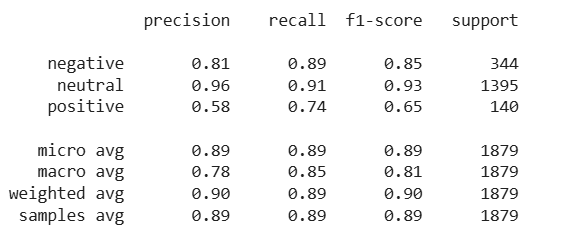

### accuracy & time

In [ ]:
import timeit

def measure_time_with_timeit(func, *args, number=1, **kwargs):

    result = func(*args, **kwargs)
    elapsed_time = timeit.timeit(lambda: func(*args, **kwargs), number=number) / number

    return result, elapsed_time

In [ ]:
evaluator = Evaluator_tf(tf_model)
result, elapsed_time = measure_time_with_timeit(evaluator.eval, test_texts, test_labels, number=3)
print(f"Результат: {result}, Среднее время выполнения: {elapsed_time:.6f} секунд")

Результат:               precision    recall  f1-score   support

    negative       0.81      0.89      0.85       344
     neutral       0.96      0.91      0.93      1395
    positive       0.58      0.74      0.65       140

   micro avg       0.89      0.89      0.89      1879
   macro avg       0.78      0.85      0.81      1879
weighted avg       0.90      0.89      0.90      1879
 samples avg       0.89      0.89      0.89      1879
, Среднее время выполнения: 35.127375 секунд


In [ ]:
evaluator = Evaluator_tf(mg_pruned_model_1)
result, elapsed_time = measure_time_with_timeit(evaluator.eval, test_texts, test_labels, number=3)
print(f"Результат: {result}, Среднее время выполнения: {elapsed_time:.6f} секунд")

Результат:               precision    recall  f1-score   support

    negative       0.79      0.92      0.85       344
     neutral       0.96      0.91      0.93      1395
    positive       0.62      0.70      0.66       140

   micro avg       0.89      0.89      0.89      1879
   macro avg       0.79      0.84      0.81      1879
weighted avg       0.90      0.89      0.90      1879
 samples avg       0.89      0.89      0.89      1879
, Среднее время выполнения: 33.352417 секунд


In [ ]:
import time
import numpy as np

vectorizer = Vectorizer()
X_ids = []
X_masks = []
for text in test_texts[:10]:
    _, input_ids, input_masks, _ = vectorizer.vectorize(text, np.zeros([1, 3]))
    X_ids.append(np.array(input_ids))
    X_masks.append(np.array(input_masks))

input_data = [np.asarray(X_ids, dtype='int32'), np.asarray(X_masks, dtype='int32')]
X_ids = np.asarray(X_ids, dtype='int32')
X_masks = np.asarray(X_masks, dtype='int32')

for model in [tf_model, mg_pruned_model_1, mg_pruned_model_2]:
  preds = model(input_data)[0]
  max_index = np.argmax(preds, axis=1)
  label_one_hot = np.eye(3)[max_index]

  execution_times = []

  for i in range(10):
      start_time = time.time()
      model.predict([X_ids[i:i+1], X_masks[i:i+1]], verbose=0)
      end_time = time.time()
      execution_times.append(end_time - start_time)

  # Вычисляем среднее время выполнения
  average_execution_time = np.mean(execution_times)

  print(f"Среднее время выполнения predict: {average_execution_time:.4f} секунд")

  #all_y_true = test_labels[:10]
  #all_y_pred = label_one_hot

  #report = classification_report(all_y_true, all_y_pred, target_names=['negative', 'neutral', 'positive'])
  #print(report)


Среднее время выполнения predict: 0.0817 секунд
Среднее время выполнения predict: 0.0784 секунд
Среднее время выполнения predict: 0.0786 секунд


## Clustering

In [ ]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip uninstall numpy
!pip install numpy==2.1.0

In [ ]:
! pip install numpy

In [ ]:
import tensorflow_model_optimization as tfmot

### Preparing model

In [ ]:
import torch
import tensorflow as tf
from transformers import BertModel, BertConfig, BertForSequenceClassification, TFBertForSequenceClassification, BertTokenizer

In [ ]:
def get_model(model_name):
    if model_name == 'tf_bert_for_sequence_classification':
        config = BertConfig.from_pretrained('DeepPavlov/rubert-base-cased', from_pt=True, num_labels=3)
        tf_model = TFBertForSequenceClassification.from_pretrained(
            "DeepPavlov/rubert-base-cased",
            from_pt=True,
            config=config
        )
        return tf_model

In [ ]:
pretrained_model = get_model('tf_bert_for_sequence_classification')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def apply_clustering_to_model(model):
    clustering_params = {
        'number_of_clusters': 32,
        'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR
    }
    for layer in model.layers:
        if hasattr(model, 'bert') and hasattr(model.bert, 'encoder'):
            encoder = model.bert.encoder
            for layer in encoder.layer:
                # attention
                if hasattr(layer, 'attention'):
                    attention = layer.attention.self_attention
                    # query, key, value
                    if hasattr(attention, 'query'):
                        attention.query = tfmot.clustering.keras.cluster_weights(attention.query, **clustering_params)
                        # print(attention.query)
                    if hasattr(attention, 'key'):
                        attention.key = tfmot.clustering.keras.cluster_weights(attention.key, **clustering_params)
                        # print(attention.key)
                    if hasattr(attention, 'value'):
                        attention.value = tfmot.clustering.keras.cluster_weights(attention.value, **clustering_params)
                        # print(attention.value)
                # intermediate dense
                if hasattr(layer, 'intermediate') and hasattr(layer.intermediate, 'dense'):
                    layer.intermediate.dense = tfmot.clustering.keras.cluster_weights(layer.intermediate.dense, **clustering_params)
                # output dense
                # if hasattr(attention, 'output') and hasattr(attention.output, 'dense'):
                #     attention.output.dense = tfmot.clustering.keras.cluster_weights(attention.output.dense, **clustering_params)

    return model

In [ ]:
pretrained_model = tf_model
clustered_model = apply_clustering_to_model(pretrained_model)

### Fine-tuning

In [ ]:
class Trainer:

    def __init__(self, vectorizer, samples_train, samples_dev, model, class_weights_dict, path_to_weights, batch_size=12, epochs=10, patience=3):
        self._vectorizer = vectorizer
        self._model = model

        self._batch_size = batch_size
        self._epochs = epochs
        self._patience = patience

        self.class_weights_dict = class_weights_dict
        self._path_to_weights = path_to_weights

        self._model.load_weights(self._path_to_weights)

        self._samples_train = samples_train
        self._samples_dev = samples_dev

        print(f'{len(self._samples_train)} train samples, {len(self._samples_dev)} val samples')

        self._steps_per_epoch = int(len(self._samples_train) / self._batch_size)
        self._validation_steps = int(len(self._samples_dev) / self._batch_size)

        self._num_of_train_samples = self._steps_per_epoch * self._batch_size
        self._num_of_val_samples = self._validation_steps * self._batch_size

    def _generate_samples(self, samples, num_of_samples):
        i = 0
        while True:
            batch_samples = samples[i:i + self._batch_size]
            texts = [sample[0] for sample in batch_samples]
            labels = [sample[1] for sample in batch_samples]
            X_ids = []
            X_masks = []
            y = []
            i += self._batch_size
            for text, token_labels in zip(texts, labels):
                _, input_ids, input_masks, tag = self._vectorizer.vectorize(text, token_labels)
                X_ids.append(np.array(input_ids))
                y.append(tag)
                X_masks.append(np.array(input_masks))
            yield [np.asarray(X_ids, dtype='int32'), np.asarray(X_masks, dtype='int32')], np.array(y)
            if i == num_of_samples:
                i = 0

    def train(self):
        saver = tf.keras.callbacks.ModelCheckpoint(
            self._path_to_weights,
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            mode='auto',
            save_weights_only=True
        )
        stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=self._patience,
            verbose=1,
            mode='auto'
        )
        self._model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy()]
        )
        history = self._model.fit(
            self._generate_samples(self._samples_train, self._num_of_train_samples),
            epochs=self._epochs,
            validation_data=self._generate_samples(self._samples_dev, self._num_of_val_samples),
            steps_per_epoch=self._steps_per_epoch,
            validation_steps=self._validation_steps,
            verbose=1,
            callbacks=[saver, stopper],
            class_weight=self.class_weights_dict
        )
        np.save('history.npy', history.history)
        return history

In [ ]:
class Vectorizer:

    def __init__(self):
        self._tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased',
                                                        do_lower_case=False)
        self._max_length = 128

    def vectorize(self, text, label):
        try:
            tokenized_text, input_masks = self._tokenize(text)
        except:
            tokenized_text, input_masks = [], []

        input_ids = self._tokenizer.convert_tokens_to_ids(tokenized_text)

        if isinstance(label, np.ndarray):
          tag = label
        else:
          print('Here is the error!')

        input_ids = self._pad(input_ids)
        input_masks = self._pad(input_masks)

        return tokenized_text, input_ids, input_masks, tag

    def _pad(self, input):
        if len(input) >= self._max_length:
            return input[:self._max_length]
        while len(input) < self._max_length:
            input.append(0)
        return input

    def _tokenize(self, text):
        tokenized_text = self._tokenizer.tokenize(text)

        inputs = self._tokenizer.encode_plus(
            tokenized_text,
            is_pretokenized=True,
            return_attention_mask=True,
            max_length=self._max_length,
            truncation=True
        )

        return tokenized_text, inputs['attention_mask']

In [ ]:
vectorizer = Vectorizer()

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights_dict = dict(enumerate(class_weights))
class_weights_dict = {0: 1.8222739619712844, 1: 0.44909864677473343, 2: 4.453295400663822}

In [ ]:
import tensorflow.compat.v1 as tf
import numpy as np

In [ ]:
trainer = Trainer(
        vectorizer=vectorizer,
        samples_train=train_samples,
        samples_dev=dev_samples,
        model=clustered_model,
        class_weights_dict = class_weights_dict,
        path_to_weights='v2_clustered_senti_classification.weights.h5',
        epochs=5
    )
trainer.train()

5263 train samples, 2250 val samples
Epoch 1/5
438/438 [==============================] - ETA: 0s - loss: 6.1127 - categorical_accuracy: 0.7578
Epoch 1: val_loss improved from inf to 12.09576, saving model to v2_clustered_senti_classification.weights.h5


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


438/438 [==============================] - 427s 908ms/step - loss: 6.1127 - categorical_accuracy: 0.7578 - val_loss: 12.0958 - val_categorical_accuracy: 0.7504
Epoch 2/5
438/438 [==============================] - ETA: 0s - loss: 5.8063 - categorical_accuracy: 0.7382
Epoch 2: val_loss did not improve from 12.09576
438/438 [==============================] - 378s 864ms/step - loss: 5.8063 - categorical_accuracy: 0.7382 - val_loss: 12.0958 - val_categorical_accuracy: 0.7504
Epoch 3/5
438/438 [==============================] - ETA: 0s - loss: 5.6487 - categorical_accuracy: 0.7382
Epoch 3: val_loss did not improve from 12.09576
438/438 [==============================] - 379s 865ms/step - loss: 5.6487 - categorical_accuracy: 0.7382 - val_loss: 12.0958 - val_categorical_accuracy: 0.7504
Epoch 4/5
438/438 [==============================] - ETA: 0s - loss: 5.8935 - categorical_accuracy: 0.7382
Epoch 4: val_loss improved from 12.09576 to 12.09575, saving model to v2_clustered_senti_classification

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history = np.load('history.npy',allow_pickle='TRUE').item()
plt.plot([l for l in history['loss']])
plt.show()

In [ ]:
clustered_model.summary()

In [ ]:
import numpy as np

def verify_clustering(model):
    print("Проверка кластеризации:")
    for i, layer in enumerate(model.bert.encoder.layer[:1]):
        layer = layer.attention.self_attention.query
        print(f"\nlayer_{i}.attention.self_attention.query:")
        print(f"Тип слоя: {type(layer)}")
        print(f"Layer: {layer.name} ({layer.__class__.__name__})")
        print(f"Есть ли _cluster_centroids: {hasattr(layer, '_cluster_centroids')}")

        if hasattr(layer, 'weights') and layer.weights:
            weight = layer.get_weights()[0]
            unique_values = len(np.unique(weight.round(decimals=4)))
            print(f"Уникальных значений в весах: {unique_values}")

        print("\nФактические параметры кластеризации:")
        config = layer.get_config()
        print("Число кластеров:", config['number_of_clusters'])
        print("Метод инициализации:", config['cluster_centroids_init'])

verify_clustering(clustered_model)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

class Evaluator_tf:

    def __init__(self, model):
        self._vectorizer = Vectorizer()
        self._model = model
        self._model.training = False
        self._batch_size = 12

    def _predict(self, texts):
        all_labels = []

        for i in range(0, len(texts), self._batch_size):
            batch_texts = texts[i:i + self._batch_size]

            X_ids = []
            X_masks = []
            for text in batch_texts:
                _, input_ids, input_masks, _ = self._vectorizer.vectorize(text, np.zeros([1, 3]))
                X_ids.append(np.array(input_ids))
                X_masks.append(np.array(input_masks))

            input = [np.asarray(X_ids, dtype='int32'), np.asarray(X_masks, dtype='int32')]
            # print("Tensorflow inpyt:", input)
            preds = self._model(input)[0]
            # print("Tensorflow output:", self._model(input))
            max_index = np.argmax(preds, axis=1)
            label_one_hot = np.eye(3)[max_index]
            all_labels.extend(label_one_hot)

        return np.array(all_labels)

    def eval(self, test_texts, test_labels):
        all_y_true = test_labels
        all_y_pred = self._predict(test_texts)

        report = classification_report(all_y_true, all_y_pred, target_names=['negative', 'neutral', 'positive'])
        return report

In [ ]:
evaluator = Evaluator_tf(clustered_model)
print(evaluator.eval(test_texts, test_labels))

Результаты кластеризованной модели v2

In [ ]:
clustered_model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  227400192 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 227402499 (1.03 GB)
Trainable params: 177857283 (678.47 MB)
Non-trainable params: 49545216 (378.00 MB)
_________________________________________________________________


In [ ]:
def verify_clustering(model):
    print("Проверка кластеризации:")
    for i, layer in enumerate(model.bert.encoder.layer[:1]):
        layer = layer.attention.self_attention.query
        print(f"\nСлой {i}:")
        print(f"Тип слоя: {type(layer)}")
        print(f"Layer: {layer.name} ({layer.__class__.__name__})")
        print(f"Есть ли _cluster_centroids: {hasattr(layer, '_cluster_centroids')}")

        if hasattr(layer, 'weights') and layer.weights:
            weight = layer.get_weights()[0]
            unique_values = len(np.unique(weight.round(decimals=4)))
            print(f"Уникальных значений в весах: {unique_values} (должно быть ≤ 32)")

        print("\nФактические параметры кластеризации:")
        config = layer.get_config()
        print("Число кластеров:", config['number_of_clusters'])
        print("Метод инициализации:", config['cluster_centroids_init'])

verify_clustering(clustered_model)

Проверка кластеризации:

Слой 0:
Тип слоя: <class 'tensorflow_model_optimization.python.core.clustering.keras.cluster_wrapper.ClusterWeights'>
Layer: cluster_query (ClusterWeights)
Есть ли _cluster_centroids: False
Уникальных значений в весах: 731 (должно быть ≤ 32)

Фактические параметры кластеризации:
Число кластеров: 32
Метод инициализации: CentroidInitialization.LINEAR


Результаты кластеризованной модели v1

In [ ]:
verify_clustering(pretrained_model)

Проверка кластеризации:

Слой 0:
Тип слоя: <class 'tf_keras.src.layers.core.dense.Dense'>
Layer: query (Dense)
Есть ли _cluster_centroids: False
Уникальных значений в весах: 3644 (должно быть ≤ 16)
